In [1]:
!python -V

Python 3.9.15


In [2]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import mlflow

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', creation_time=1672744858653, experiment_id='1', last_update_time=1672744858653, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [5]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829626

/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_13450/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_13450/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

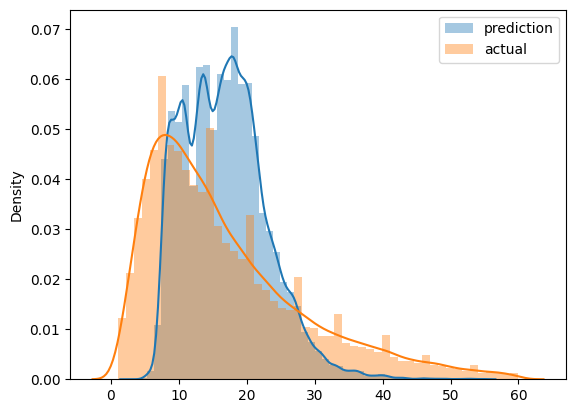

In [6]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [9]:
len(df_train), len(df_val)

(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715206931833

/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_13450/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/q8/6pzc9r955kd8whj1ss97qt080000gn/T/ipykernel_13450/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

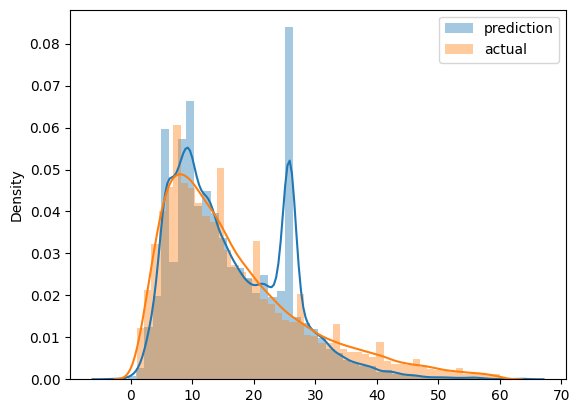

In [14]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [15]:
import os
os.makedirs('models', exist_ok=True)
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Unai")
    
    mlflow.log_param("train-data-path", './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", './data/green_tripdata_2021-02.parquet')
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_val)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [15]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [18]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        
    return {"loss": rmse, "status": STATUS_OK}

In [24]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0), # exp(-3), exp(0) -> [0.05, 1]
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[18:18:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.12000                          
[1]	validation-rmse:9.36730                           
[2]	validation-rmse:7.76363                           
[3]	validation-rmse:7.11253                           
[4]	validation-rmse:6.83597                           
[5]	validation-rmse:6.71183                           
[6]	validation-rmse:6.65125                           
[7]	validation-rmse:6.62026                           
[8]	validation-rmse:6.60388                           
[9]	validation-rmse:6.59422                           
[10]	validation-rmse:6.58755                          
[11]	validation-rmse:6.58171                          
[12]	validation-rmse:6.57752                          
[13]	validation-rmse:6.57581                          
[14]	validation-

In [19]:
best_params = {
    "max_depth": 17,
    "learning_rate": 0.32778455299306497,
    "reg_alpha": 0.01907951297374153,
    "reg_lambda": 0.0025556344556968043,
    "min_child_weight": 1.9615655166246113,
    "objective": "reg:linear",
    "seed": 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

2023/01/05 12:26:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e4d96045217742579aa6b2cc8dd8afc0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[12:26:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.45678
[1]	validation-rmse:11.83142
[2]	validation-rmse:9.62579
[3]	validation-rmse:8.33110
[4]	validation-rmse:7.59873
[5]	validation-rmse:7.17863
[6]	validation-rmse:6.94298
[7]	validation-rmse:6.80079
[8]	validation-rmse:6.71381
[9]	validation-rmse:6.65604
[10]	validation-rmse:6.62222
[11]	validation-rmse:6.59939
[12]	validation-rmse:6.58727
[13]	validation-rmse:6.57818
[14]	validation-rmse:6.57056
[15]	validation-rmse:6.56465
[16]	validation-rmse:6.55943
[17]	validation-rmse:6.55564
[18]	validation-rmse:6.55276
[19]	validation-rmse:6.55075
[20]	validation-rmse:6.54702
[21]	validation-rmse:6.54433
[22]	validation-rmse:6.54172
[23]	validation-rmse:6.53873
[24]	validation-rmse:6.53695
[25]	validation-rmse:6.53304
[26]	validation-rmse:6.52939
[27]	valida

2023/01/05 12:27:13 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
